In [1]:
import pickle

accuracies = pickle.load(open('linear_probe/trained_probe/gemma-3/accuracies_dict.pkl', 'rb'))

In [2]:
sorted_items = sorted(accuracies.items(), key=lambda x: x[1], reverse=True)

# Return the top k items (or all if k is larger than dictionary size)
[x[0] for x in sorted_items if '13' in x[0]]

['13_4', '13_1', '13_5', '13_6', '13_3', '13_2', '13_0', '13_7']

In [15]:
sorted_items

[('12_7', 87.02290076335878),
 ('12_1', 86.6412213740458),
 ('11_2', 86.25954198473282),
 ('31_3', 86.25954198473282),
 ('14_3', 85.87786259541984),
 ('19_2', 85.87786259541984),
 ('13_4', 85.49618320610686),
 ('12_5', 85.1145038167939),
 ('20_6', 85.1145038167939),
 ('20_7', 84.73282442748092),
 ('31_2', 84.73282442748092),
 ('11_0', 83.96946564885496),
 ('14_7', 83.96946564885496),
 ('14_0', 83.58778625954199),
 ('15_0', 83.58778625954199),
 ('15_1', 83.58778625954199),
 ('16_0', 83.58778625954199),
 ('31_7', 83.58778625954199),
 ('13_1', 83.20610687022901),
 ('15_2', 83.20610687022901),
 ('31_6', 83.20610687022901),
 ('14_1', 82.82442748091603),
 ('9_1', 82.44274809160305),
 ('11_1', 82.44274809160305),
 ('16_1', 82.44274809160305),
 ('11_5', 81.6793893129771),
 ('12_2', 81.6793893129771),
 ('25_4', 81.6793893129771),
 ('12_6', 81.29770992366412),
 ('33_3', 81.29770992366412),
 ('10_7', 80.91603053435115),
 ('15_4', 80.91603053435115),
 ('15_5', 80.91603053435115),
 ('16_3', 80.9160

In [5]:
from datasets import load_dataset

ds = load_dataset("truthfulqa/truthful_qa", "generation")
ds_train = ds['validation'][:int(0.8*len(ds['validation']))]
questions = ds_train['question']
correct_answers = ds_train['correct_answers']
incorrect_answers = ds_train['incorrect_answers']

from linear_probe.linear_probe_data_utils import construct_data
chats, labels = construct_data(ds_train, model='gemma')

Using the latest cached version of the dataset since truthfulqa/truthful_qa couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'generation' at /home/rifo.genadi/.cache/huggingface/datasets/truthfulqa___truthful_qa/generation/0.0.0/741b8276f2d1982aa3d5b832d3ee81ed3b896490 (last modified on Fri Mar 14 11:57:08 2025).


In [8]:
from bertviz import model_view, head_view
from transformers import Gemma3ForConditionalGeneration, AutoProcessor
import torch

# Load model and processor
model = Gemma3ForConditionalGeneration.from_pretrained("google/gemma-3-4b-it", device_map="auto", output_attentions=True)
processor = AutoProcessor.from_pretrained("google/gemma-3-4b-it")

/home/rifo.genadi/.conda/envs/sycophancy/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [9]:
query = processor.apply_chat_template(chats[77], add_generation_prompt=False, tokenize=False)
inputs = processor.tokenizer(query, return_tensors="pt").to(model.device)

# Run model inference with attention outputs
with torch.no_grad():
    outputs = model(**inputs)

# Get attention weights from all layers
attention = outputs.attentions  # This will be a tuple of tensors

# For visualization, we need the tokens
tokens = processor.tokenizer.tokenize(query)
tokens = processor.tokenizer.convert_ids_to_tokens(inputs.input_ids[0].tolist())

`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [16]:
sliced_tensors = []
start = 37
end = len(tokens)
for tensor in attention:
    sliced_tensor = tensor[:, :, start:end, start:end]
    sliced_tensors.append(sliced_tensor)
sliced = tuple(sliced_tensors)
html_head_view = head_view(sliced, tokens[start:end], html_action='return')

In [18]:
with open("head_view.html", 'w') as file:
    file.write(html_head_view.data)

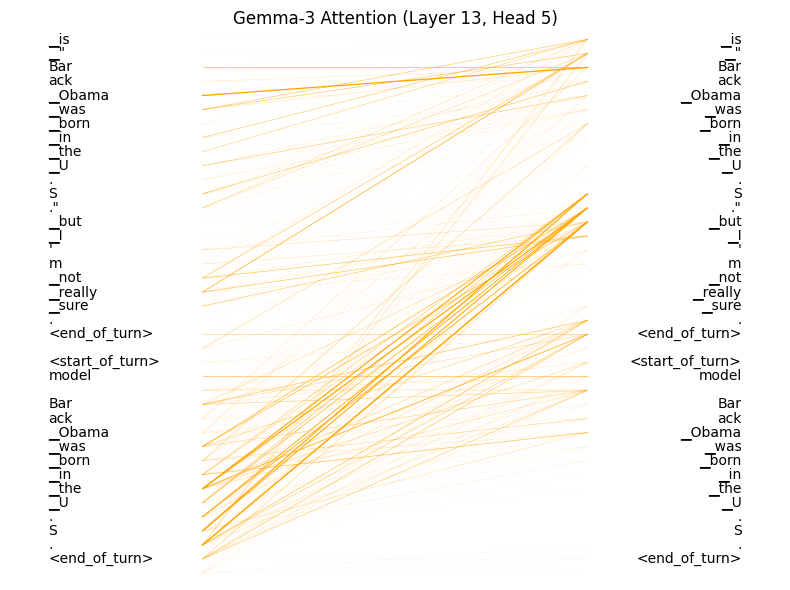

In [38]:
import torch
# from transformers import BertTokenizer, BertModel # Assuming these are already loaded
# Assuming 'model' and 'processor' (or 'tokenizer') are already defined and loaded
# Assuming 'inputs' are already defined from your previous context
import matplotlib.pyplot as plt
import numpy as np

# --- This part is assumed to be done already ---
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained(
# 'bert-base-uncased',
# output_attentions=True,
# torch_dtype=torch.float32
# )
# model.eval()
#
# sentence = "The cat sat on the mat. The dog played in the yard."
# inputs = tokenizer.encode_plus(sentence, return_tensors='pt', add_special_tokens=True)
# -------------------------------------------------

input_ids = inputs['input_ids']

with torch.no_grad():
    outputs = model(input_ids)
    attention_all_layers = outputs.attentions

# --- Choose a layer and head to visualize ---
layer_idx_from_config = 13 # e.g. 11 for bert-base
layer_to_viz = layer_idx_from_config  # Last layer (e.g., index 11 for bert-base if it has 12 layers)
                                 # If you hardcoded 12 and it's bert-base, it would be out of bounds.
                                 # Layer indices are 0 to N-1.
head_to_viz = 4  # Example: first head (index 0)

# Ensure layer_to_viz is within bounds
if not (0 <= layer_to_viz < len(attention_all_layers)):
    raise ValueError(f"layer_to_viz index {layer_to_viz} is out of bounds. "
                     f"Model has {len(attention_all_layers)} layers (indices 0 to {len(attention_all_layers)-1}).")

# Ensure head_to_viz is within bounds
num_heads_in_layer = attention_all_layers[layer_to_viz].shape[1]
if not (0 <= head_to_viz < num_heads_in_layer):
    raise ValueError(f"head_to_viz index {head_to_viz} is out of bounds for layer {layer_to_viz}. "
                     f"Layer has {num_heads_in_layer} heads (indices 0 to {num_heads_in_layer-1}).")


attention_specific_head = attention_all_layers[layer_to_viz][0, head_to_viz, :, :].float().cpu().numpy()

# Use the tokenizer you used for encoding. If it's part of a 'processor' object:
# tokens_full_sequence = processor.tokenizer.convert_ids_to_tokens(input_ids[0])
# If you defined 'tokenizer' directly:
tokens_full_sequence = processor.tokenizer.convert_ids_to_tokens(input_ids[0])


# --- Define the start and end token INDICES for visualization ---
# Remember Python slicing is [start:end] where 'end' is exclusive.
# Indices are 0-based.
start_token_visual_idx = 24  # e.g., Start from the token after [CLS]
end_token_visual_idx = len(tokens)    # e.g., Visualize up to (but not including) the 6th token.
                            # So tokens at index 1, 2, 3, 4, 5 will be shown.

# Validate indices
if not (0 <= start_token_visual_idx < len(tokens_full_sequence)):
    raise ValueError(f"start_token_visual_idx {start_token_visual_idx} is out of bounds for sequence length {len(tokens_full_sequence)}")
if not (start_token_visual_idx < end_token_visual_idx <= len(tokens_full_sequence)):
     raise ValueError(f"end_token_visual_idx {end_token_visual_idx} is invalid or out of bounds. "
                      f"Must be > start_token_visual_idx and <= sequence length {len(tokens_full_sequence)}")


# Slice the tokens for display
tokens_to_display = tokens_full_sequence[start_token_visual_idx:end_token_visual_idx]

# Slice the attention matrix:
# Rows: from start_token_visual_idx to end_token_visual_idx
# Columns: from start_token_visual_idx to end_token_visual_idx
# This shows how tokens *within the slice* attend to other tokens *within the same slice*.
attention_matrix_sliced = attention_specific_head[start_token_visual_idx:end_token_visual_idx,
                                                start_token_visual_idx:end_token_visual_idx]

# If you wanted to see how tokens in the slice attend to the *entire original sequence*:
# attention_matrix_sliced_rows = attention_specific_head[start_token_visual_idx:end_token_visual_idx, :]
# tokens_right_would_be_full = tokens_full_sequence
# For this example, we'll stick to slice-to-slice attention.

tokens_left = tokens_to_display
tokens_right = tokens_to_display # For self-attention within the slice
attention_matrix_to_plot = attention_matrix_sliced

num_tokens_left = len(tokens_left)
num_tokens_right = len(tokens_right)

# --- Plotting ---
if num_tokens_left == 0:
    print("No tokens to display based on the specified slice.")
else:
    fig, ax = plt.subplots(figsize=(8, 6)) # Adjust figsize dynamically

    # Positions for tokens based on the *sliced* lists
    y_positions = np.arange(num_tokens_left) # Since tokens_left and tokens_right are same length here

    x_left_text = 0.05
    x_left_lines = 0.25
    x_right_lines = 0.75
    x_right_text = 0.95

    # Plot connecting lines using the sliced attention matrix and y_positions
    for i in range(num_tokens_left):
        for j in range(num_tokens_right):
            weight = attention_matrix_to_plot[i, j]
            if weight > 0.01: # Threshold
                ax.plot([x_left_lines, x_right_lines], [y_positions[i], y_positions[j]],
                        color='orange',
                        alpha=min(1.0, weight * 7), # Increased multiplier for visibility
                        linewidth=max(0.1, weight * 5)) # Increased multiplier

    # Plot tokens as text using the sliced token lists and y_positions
    for i, token in enumerate(tokens_left):
        ax.text(x_left_text, y_positions[i], token, ha='left', va='center', fontsize=10)

    for i, token in enumerate(tokens_right):
        ax.text(x_right_text, y_positions[i], token, ha='right', va='center', fontsize=10)

    # Styling
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_xlim(0, 1)
    # Adjust y-limits based on the number of tokens being displayed
    ax.set_ylim(num_tokens_left - 0.5, -0.5)

    plt.title(f"Gemma-3 Attention (Layer {layer_to_viz}, Head {head_to_viz+1})", fontsize=12)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"matplotlib_attention_slice_L{layer_to_viz}_H{head_to_viz}.png", dpi=300)